# Benchmarking pipeline

Biological activities can be estimated by coupling a statistical method with a prior knowledge network. However, it is not clear which method or network performs better. When perturbation experiments are available, one can benchmark these methods by evaluating how good are they at recovering perturbed regulators. In our original `decoupler` [publication](https://doi.org/10.1093/bioadv/vbac016), we observed that `wsum`, `mlm`, `ulm` and `consensus` where the top performer methods. 

In this notebook we showcase how to use `decoupler` for the benchmarking of methods and prior knowledge networks. The data used here consist of single-gene perturbation experiments from the [KnockTF2](http://www.licpathway.net/KnockTFv2/index.php) database, an extensive dataset of literature curated perturbation experiments. If you use these data for your resarch, please cite the original publication of the resource:

>Chenchen Feng, Chao Song, Yuejuan Liu, Fengcui Qian, Yu Gao, Ziyu Ning, Qiuyu Wang, Yong Jiang, Yanyu Li, Meng Li, Jiaxin Chen, Jian Zhang, Chunquan Li, KnockTF: a comprehensive human gene expression profile database with knockdown/knockout of transcription factors, Nucleic Acids Research, Volume 48, Issue D1, 08 January 2020, Pages D93–D100, https://doi.org/10.1093/nar/gkz881

生物学的活性は、統計的手法と事前知識ネットワークを組み合わせることで推定できる。しかし、どの手法やネットワークが優れているかは明らかではない。摂動実験が可能であれば、摂動された制御因子を回復させるのにどの程度優れているかを評価することで、これらの手法をベンチマークすることができる。私たちが最初に発表したdecouplerでは、wsum、mlm、ulm、consensusが上位を占めました。

このノートブックでは、手法と事前知識ネットワークのベンチマークにdecouplerを使用する方法を紹介する。ここで使用したデータはKnockTF2データベースの単一遺伝子摂動実験です。これらのデータを研究に使用する場合は、そのリソースの原著を引用してください：

## Loading packages

First, we need to load the relevant packages.

まず、関連するパッケージをロードする必要がある。

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
import decoupler as dc

## Loading the data

We can download the data easily from Zenodo:

データはZenodoから簡単にダウンロードできる：

In [5]:
!wget 'https://zenodo.org/record/7035528/files/knockTF_expr.csv?download=1' -O knockTF_expr.csv
!wget 'https://zenodo.org/record/7035528/files/knockTF_meta.csv?download=1' -O knockTF_meta.csv

--2024-08-08 23:16:58--  https://zenodo.org/record/7035528/files/knockTF_expr.csv?download=1
zenodo.org (zenodo.org) をDNSに問いあわせています... 188.184.98.238, 188.185.79.172, 188.184.103.159
zenodo.org (zenodo.org)|188.184.98.238|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 301 MOVED PERMANENTLY
場所: /records/7035528/files/knockTF_expr.csv [続く]
--2024-08-08 23:17:00--  https://zenodo.org/records/7035528/files/knockTF_expr.csv
zenodo.org:443 への接続を再利用します。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 146086808 (139M) [text/plain]
`knockTF_expr.csv' に保存中

knockTF_expr.csv    100%[===================>] 139.32M  2.98MB/s 時間 50s        

2024-08-08 23:17:50 (2.81 MB/s) - `knockTF_expr.csv' へ保存完了 [146086808/146086808]

--2024-08-08 23:17:51--  https://zenodo.org/record/7035528/files/knockTF_meta.csv?download=1
zenodo.org (zenodo.org) をDNSに問いあわせています... 188.185.79.172, 188.184.103.159, 188.184.98.238
zenodo.org (zenodo.org)|188.185.79.172|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています

We can then read it using `pandas`:

そしてpandasを使ってそれを読むことができる：

In [6]:
# Read data
mat = pd.read_csv('knockTF_expr.csv', index_col=0)
obs = pd.read_csv('knockTF_meta.csv', index_col=0)

`mat` consist of a matrix of logFCs between the perturbed and the control samples. Positive values mean that these genes were
overexpressed after the perturbation, negative values mean the opposite.

matは、摂動サンプルとコントロールサンプルの間のlogFCのマトリックスからなる。正の値は、これらの遺伝子が摂動後に過剰発現したことを意味し、負の値はその逆を意味する。

In [7]:
mat.head()

,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AA06,AAA1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
DataSet_01_001,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.00000,0.00000,-0.03322,-0.04690,-0.14383,0.00000
DataSet_01_002,-0.17375,0.00000,-0.53779,-0.4424,-1.59664,-0.00010,-0.08260,-3.64590,0.0,0.0,...,0.0,0.39579,0.0,0.08611,0.28574,-0.13021,-0.27664,-0.88158,0.81295,0.47896
DataSet_01_003,-0.21613,0.00000,-0.22027,-0.0008,0.00000,0.15580,-0.35802,-0.32025,0.0,0.0,...,0.0,-0.82964,0.0,0.06447,0.59323,0.31395,-0.23260,0.06551,-0.14714,0.00000
DataSet_01_004,-0.25568,0.11105,-0.28527,0.0000,-0.03586,-0.46970,0.18559,-0.25601,0.0,0.0,...,0.0,-0.39888,0.0,0.10444,-0.16434,0.19146,0.41561,0.39384,0.12790,0.00000
DataSet_01_005,0.47850,-0.37571,-0.84718,0.0000,3.35445,0.17104,-0.34852,-0.95517,0.0,0.0,...,0.0,0.24849,0.0,-0.28692,-0.01815,0.11941,0.07785,0.23474,0.22869,0.00000


On the other hand, `obs` contains the meta-data information of each perturbation experiment.
Here one can find which TF was perturbed (`TF` column), and many other useful information.

一方、obsには各摂動実験のメタデータ情報が含まれている。ここでは、どのTFが摂動されたか（TFカラム）、その他多くの有用な情報を得ることができる。

In [8]:
obs.head()

,TF,Species,Knock.Method,Biosample.Name,Profile.ID,Platform,TF.Class,TF.Superclass,Tissue.Type,Biosample.Type,Data.Source,Pubmed.ID,logFC
DataSet_01_001,ESR1,Homo sapiens,siRNA,MCF7,GSE10061,GPL3921,Nuclear receptors with C4 zinc fingers,Zinc-coordinating DNA-binding domains,Mammary_gland,Cell line,GEO,18631401,-0.71385
DataSet_01_002,HNF1A,Homo sapiens,shRNA,HuH7,GSE103128,GPL18180,Homeo domain factors,Helix-turn-helix domains,Liver,Cell line,GEO,29466992,0.16428
DataSet_01_003,MLXIP,Homo sapiens,shRNA,HA1ER,GSE11242,GPL4133,Basic helix-loop-helix factors (bHLH),Basic domains,Embryo_kidney,Stem cell,GEO,18458340,0.26215
DataSet_01_004,CREB1,Homo sapiens,shRNA,K562,GSE12056,GPL570,Basic leucine zipper factors (bZIP),Basic domains,Haematopoietic_and_lymphoid_tissue,Cell line,GEO,18801183,-0.95018
DataSet_01_005,POU5F1,Homo sapiens,siRNA,GBS6,GSE12320,GPL570,Homeo domain factors,Helix-turn-helix domains,Bone_marrow,Cell line,GEO,20203285,0.00000


## Filtering

Since some of the experiments collected inside KnockTF are of low quality, it is best to remove them. We can do this by filtering
perturbation experiments where the knocked TF does not show a strong negative logFC (meaning that the knock method did not work).


KnockTFの中で収集された実験のいくつかは質が低いので、それらを除去するのが最善である。これは、ノックされたTFが強い負のlogFCを示さない（ノック法が機能しなかったことを意味する）摂動実験をフィルタリングすることによって行うことができる。

In [9]:
# Filter out low quality experiments (positive logFCs in knockout experiments)
msk = obs['logFC'] < -1
mat = mat[msk]
obs = obs[msk]

In [10]:
mat.head()

,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AA06,AAA1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
DataSet_01_006,-0.41056,3.13675,-0.49427,0.00000,0.23968,1.37572,-0.03733,0.56758,0.0,0.0,...,0.0,-0.39262,0.0,-0.24752,-0.03830,-0.05072,0.17918,-0.17708,0.08701,0.0
DataSet_01_007,-0.50900,2.12951,-0.16245,0.00000,0.02671,-0.61539,0.06548,0.87137,0.0,0.0,...,0.0,-0.22490,0.0,-0.17279,-0.54982,-0.22164,-0.13836,0.23519,0.13498,0.0
DataSet_01_008,-0.25537,0.06701,0.31111,0.00000,-0.02576,-0.15574,0.00037,-0.14773,0.0,0.0,...,0.0,0.35065,0.0,0.15874,0.04277,0.34284,-0.09468,0.16314,0.02952,0.0
DataSet_01_010,0.05667,0.00000,0.81121,0.46618,-0.45087,0.05971,0.00786,-0.30456,0.0,0.0,...,0.0,1.63275,0.0,0.40010,1.81472,0.32373,-0.30996,0.39868,0.77080,0.0
DataSet_01_011,-0.03059,0.00000,0.00000,0.00000,-1.20615,0.00000,0.57765,0.00000,0.0,0.0,...,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.08458,0.00000,0.00000,0.0


In [11]:
mat.shape

(388, 21985)

In [12]:
obs.head()

,TF,Species,Knock.Method,Biosample.Name,Profile.ID,Platform,TF.Class,TF.Superclass,Tissue.Type,Biosample.Type,Data.Source,Pubmed.ID,logFC
DataSet_01_006,PROX1,Homo sapiens,siRNA,Primary lymphatic endothelial cells,GSE12846,GPL570,Homeo domain factors,Helix-turn-helix domains,Foreskin,Primary cell,GEO,18815287,-1.13977
DataSet_01_007,NR2F2,Homo sapiens,siRNA,Primary lymphatic endothelial cells,GSE12846,GPL570,Nuclear receptors with C4 zinc fingers,Zinc-coordinating DNA-binding domains,Foreskin,Primary cell,GEO,18815287,-1.34696
DataSet_01_008,WT1,Homo sapiens,siRNA,PLC/PRF/5,GSE12886,GPL570,C2H2 zinc finger factors,Zinc-coordinating DNA-binding domains,Liver,Cell line,GEO,19190340,-1.11474
DataSet_01_010,TP53,Homo sapiens,shRNA,iPS cells,GSE13334,GPL4133,p53 domain factors,Immunoglobulin fold,Dermal_fibroblasts,Induced pluripotent stem cell,GEO,19668191,-3.13745
DataSet_01_011,TP53,Homo sapiens,siRNA,U251,GSE13991,GPL1426,p53 domain factors,Immunoglobulin fold,Central_nervous_system,Cell line,GEO,19139068,-2.43895


In [13]:
obs.shape

(388, 13)

## Evaluation

### Single network

As an example, we will evaluate the gene regulatory network
[CollecTRI](https://github.com/saezlab/CollecTRI), for more information you can visit this
[other vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/dorothea.html).

We can retrieve this network by running:

例として、遺伝子制御ネットワークCollecTRIを評価する。

このネットワークは

In [14]:
# Get collectri
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [15]:
collectri.head()

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...


We will run the benchmark pipeline using the top performer methods from `decoupler`. If we would like, we could use any other,
and we can optionaly change their parametters too (for more information check the `decouple` function).

To run the benchmark pipeline, we need input molecular data (`mat`), its associated metadata (`obs`) with the name of the
column where the perturbed regulators are (`perturb`), and which direction the pertrubations are (`sign`, positive or negative).
    
Note that if you want to ignore missing values in the input `mat` (denoted as zeros), you can add the parameter `'dense': True` to `decouple_kws`.

decouplerのトップパフォーマーのメソッドを使ってベンチマークパイプラインを実行する。必要であれば、他のメソッドも使用することができ、オプションでパラメータを変更することもできます（詳細はdecouple関数を参照してください）。

ベンチマークパイプラインを実行するには、分子データ(mat)、それに関連するメタデータ(obs)、摂動が加えられたカラムの名前(perturb)、摂動の方向(sign, positive or negative)を入力する必要がある。

入力マットの欠損値（ゼロ）を無視したい場合は、'dense' パラメータを追加してください： を指定します。

In [16]:
# Example on how to set up decouple arguments
decouple_kws={
    'methods' : ['wsum', 'ulm', 'mlm'],
    'consensus': True,
    'args' : {
        'wsum' : {'times': 100}
    }
}

In [17]:
# Run benchmark pipeline
df = dc.benchmark(
    mat, obs, collectri,
    perturb='TF', sign=-1, verbose=True,
    decouple_kws=decouple_kws
)

Extracting inputs...
Formating net...
Removed 109 experiments without sources in net.
Running 279 experiments for 155 unique sources.
Running methods...
52 features of mat are empty, they will be removed.
Running wsum on mat with 279 samples and 21933 targets for 766 sources.
52 features of mat are empty, they will be removed.
Running ulm on mat with 279 samples and 21933 targets for 766 sources.
52 features of mat are empty, they will be removed.
Running mlm on mat with 279 samples and 21933 targets for 766 sources.
Calculating metrics...
Computing metrics...
Done.


The result of running the pipeline is a long-format dataframe containing different performance metrics across methods:

- `auroc`: Area Under the Receiver Operating characteristic Curve (AUROC)
- `auprc`: Area Under the Precision-Recall Curve (AUPRC), which by default uses a calibrated version where 0.5 indicates a random classifier (adapted from [this publication](https://doi.org/10.1007/978-3-030-44584-3_36)).
- `mauroc`: Monte-Carlo Area Under the Precision-Recall Curve (AUPRC)
- `mauprc`: Monte-Carlo Area Under the Receiver Operating characteristic Curve (AUROC)
- `rank`: Rank of the perturbed source per experiment.
- `nrank`: Normalized rank of the perturbed source per experiment (close to 0 is better).

The Monte-Carlo metrics perform random permutations where each one samples the same number of true positives and true negatives to have balanced sets, returning one value per iteration done (10k by default).

パイプラインの実行結果は、メソッド間で異なるパフォーマンスメトリクスを含むロングフォーマットのデータフレームです：

- auroc： AUROC: 動作特性曲線下面積 (AUROC)
- auprc： Area Under the Precision-Recall Curve (AUPRC)。デフォルトでは、0.5がランダム分類器を示す較正バージョンを使用します（この出版物から引用）。
- mauroc： モンテカルロ精度再現曲線下面積 (AUPRC)
- mauprc： レシーバ動作特性曲線下モンテカルロ面積 (AUROC)
- ランク 実験ごとの摂動ソースのランク。
- nrank: 実験ごとの摂動ソースの正規化ランク（0に近いほど良い）。

Monte-Carlo メトリクスは、バランスのとれた集合になるように、各々が同じ数の真陽性と真陰性をサンプリングするランダムな並べ替えを実行し、実行された反復ごとに1つの値を返す（デフォルトでは10k）。

In [18]:
df.head()

,groupby,group,source,method,metric,score,ci
0,None,None,None,wsum_estimate,auroc,0.713571,0.001305
1,None,None,None,wsum_estimate,auprc,0.738849,0.001305
2,None,None,None,wsum_estimate,mcauroc,0.717372,0.001305
3,None,None,None,wsum_estimate,mcauroc,0.731504,0.001305
4,None,None,None,wsum_estimate,mcauroc,0.713069,0.001305


We can easily visualize the results in a scatterplot: 

結果は散布図で簡単に視覚化できる： 

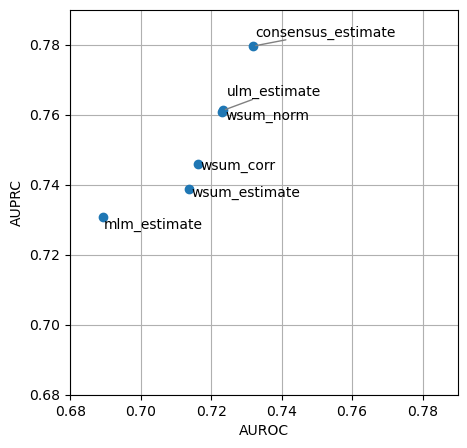

In [19]:
dc.plot_metrics_scatter(df, x='auroc', y='auprc')

It looks like `mlm` this time had worse performance than other methods like `ulm` at recovering
perturbed regulators, this might be caused because there are many TFs that share too many targets.
Whenever there are multiple sources (TFs) and they share a lot of targets we recommend to use `ulm`.
On the other hand, when there are few sources and they are orthogonal (they share few targets), we recommend to use `mlm`.
Since `consensus` remains one of the top performer methods we also recommend its use but at a higher computational cost and less interpretability.

We can also visualise the distirbutions of the obtained metrics, for example `mcauroc`, `mcauprc`, `rank` and `nrank`:

今回のmlmは、ulmのような他の方法よりも摂動制御因子を回復させるパフォーマンスが悪かったようだ。これは、ターゲットを共有するTFが多すぎるためかもしれない。複数のソース（TF）があり、それらが多くのターゲットを共有している場合は、ulmを使うことを推奨する。一方、ソースが少なく、それらが直交している（ターゲットを共有しているものが少ない）場合は、mlmを使うことを推奨する。コンセンサスは依然としてトップ・パフォーマーの手法の1つであるため、その使用も推奨するが、計算コストが高くなり、解釈可能性が低くなる。

mcauroc、mcauprc、rank、nrankなど、得られたメトリクスの分布を可視化することもできます：

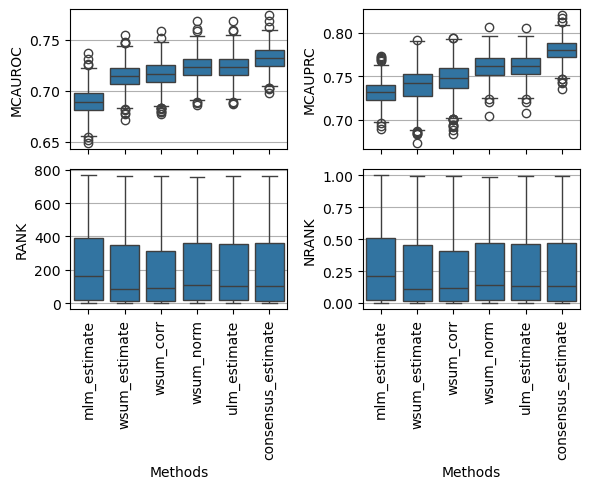

In [20]:
fig, axes = plt.subplots(
    2, 2, figsize=(6, 5),
    sharex=True, tight_layout=True
)

dc.plot_metrics_boxplot(df, metric='mcauroc', ax=axes[0, 0])

dc.plot_metrics_boxplot(df, metric='mcauprc', ax=axes[0, 1])

dc.plot_metrics_boxplot(df, metric='rank', ax=axes[1, 0])

dc.plot_metrics_boxplot(df, metric='nrank', ax=axes[1, 1])

### Multiple networks

This pipeline can evaluate multiple networks at the same time. Now we will evaluate CollecTRI and
[DoRothEA](https://saezlab.github.io/dorothea/), a literature-based network that we developed in the past.
We will also add a randomized version as control.

このパイプラインは複数のネットワークを同時に評価することができます。ここでは、CollecTRIと、過去に開発した文献ベースのネットワークであるDoRothEAを評価する。また、コントロールとしてランダム化バージョンも追加する。

In [21]:
# Get dorothea
dorothea = dc.get_dorothea(organism='human')

0.00B [00:00, ?B/s]

In [22]:
# Randomize nets
ctri_rand = dc.shuffle_net(
    collectri, target='target', weight='weight'
).drop_duplicates(['source', 'target'])

In [23]:
doro_rand = dc.shuffle_net(
    dorothea, target='target', weight='weight'
).drop_duplicates(['source', 'target'])

We can run the same pipeline but now using a dictionary of networks (and of extra arguments if needed).

同じパイプラインを実行できるが、今度はネットワークの辞書を使う（必要であれば追加の引数も）。

In [24]:
# Build dictionary of networks to test
nets = {
    'r_collectri': ctri_rand,
    'r_dorothea': doro_rand,
    'collectri': collectri,
    'dorothea': dorothea,
}

In [25]:
# Example extra arguments
decouple_kws = {
    'r_collectri': {
        'methods' : ['ulm', 'mlm'],
        'consensus': True
    },
    'r_dorothea': {
        'methods' : ['ulm', 'mlm'],
        'consensus': True
    },
    'collectri': {
        'methods' : ['ulm', 'mlm'],
        'consensus': True
    },
    'dorothea': {
        'methods' : ['ulm', 'mlm'],
        'consensus': True
    }
}

In [26]:
# Run benchmark pipeline
df = dc.benchmark(
    mat, obs, nets, perturb='TF', sign=-1, verbose=True,
    decouple_kws=decouple_kws
)

Using r_collectri network...
Extracting inputs...
Formating net...
Removed 109 experiments without sources in net.
Running 279 experiments for 155 unique sources.
Running methods...
52 features of mat are empty, they will be removed.
Running ulm on mat with 279 samples and 21933 targets for 762 sources.
52 features of mat are empty, they will be removed.
Running mlm on mat with 279 samples and 21933 targets for 762 sources.
Calculating metrics...
Computing metrics...
Done.
Using r_dorothea network...
Extracting inputs...
Formating net...
Removed 175 experiments without sources in net.
Running 213 experiments for 104 unique sources.
Running methods...
55 features of mat are empty, they will be removed.
Running ulm on mat with 213 samples and 21930 targets for 295 sources.
55 features of mat are empty, they will be removed.
Running mlm on mat with 213 samples and 21930 targets for 295 sources.
Calculating metrics...
Computing metrics...
Done.
Using collectri network...
Extracting inputs.

Like before we can try to visualize the results in a scatterplot, this time grouping by the network used:

前回同様、散布図で結果を視覚化してみよう。今回は使用したネットワークでグループ化した：

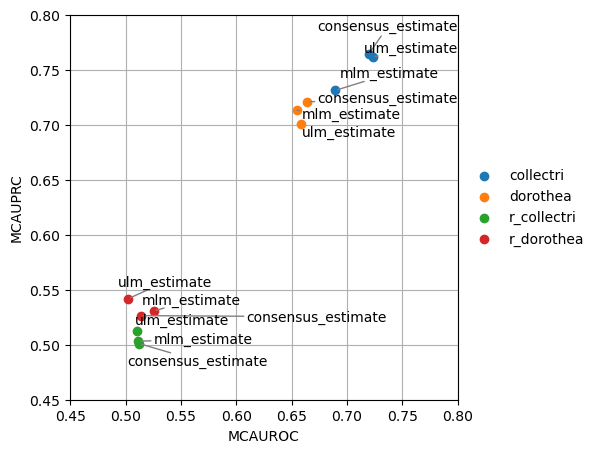

In [27]:
dc.plot_metrics_scatter(
    df, groupby='net', x='mcauroc', y='mcauprc'
)

Since this plot is too crowded, we can plot it again separating the methods by columns:

このプロットは混雑しすぎているので、メソッドを列で区切って再度プロットしてみよう：

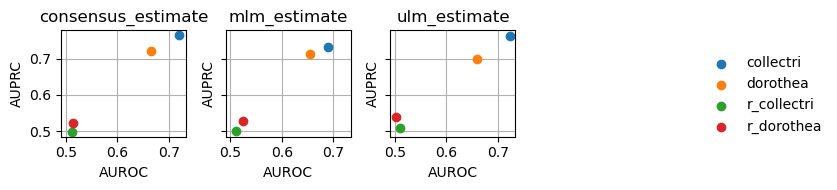

In [28]:
dc.plot_metrics_scatter_cols(
    df, col='method', x='auroc', y='auprc',
    figsize=(7, 2), groupby='net'
)

Or by selecting only one of the methods, in this case `consensus`:

あるいは、いずれかの方法（この場合はコンセンサス）のみを選択することによっても：

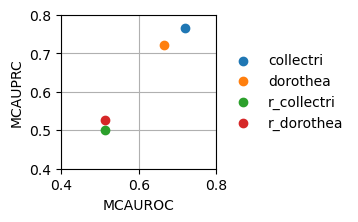

In [29]:
dc.plot_metrics_scatter(
    df[df['method'] == 'consensus_estimate'],
    groupby='net', x='mcauroc', y='mcauprc',
    show_text=False, figsize=(2, 2)
)

As expected, the random network has a performance close to 0.5 while the rest show higher predictive performance. As previously reported, the collectri network has better performance than dorothea.

If needed, we can also plot the distributions of the Monte-Carlo metrics, now grouped by network:

予想通り、ランダムネットワークは0.5に近い性能を示したが、その他のネットワークはより高い予測性能を示した。以前に報告したように、collectriネットワークはdorotheaよりも優れた性能を持つ。

必要であれば、モンテカルロメトリクスの分布をプロットすることもできる：

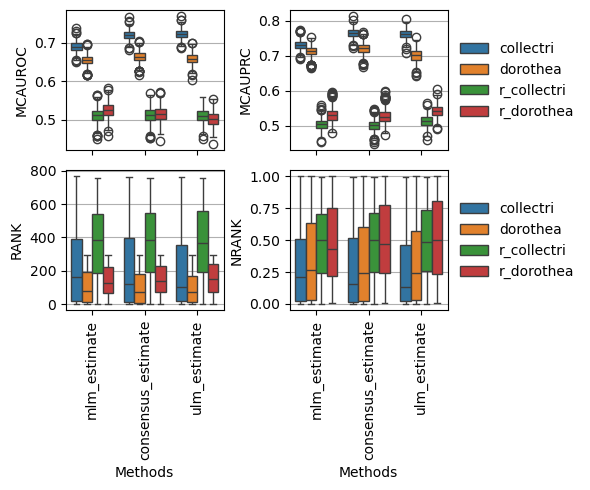

In [30]:
fig, axes = plt.subplots(
    2, 2, figsize=(6, 5), sharex=True, tight_layout=True
)

dc.plot_metrics_boxplot(df, metric='mcauroc', groupby='net', ax=axes[0, 0], legend=False)

dc.plot_metrics_boxplot(df, metric='mcauprc', groupby='net', ax=axes[0, 1], legend=True)

dc.plot_metrics_boxplot(df, metric='rank', groupby='net', ax=axes[1, 0], legend=False)

dc.plot_metrics_boxplot(df, metric='nrank', groupby='net', ax=axes[1, 1])

### By source

The benchmark pipeline also allows to test the performance of individual regulators using the argument `by='source'`. For simplicity let us just use the best performing network:

ベンチマークパイプラインでは、引数by='source'を使用して、個々のレギュレータのパフォーマンスをテストすることもできます。簡単のため、最も性能の良いネットワークだけを使用してみましょう：

In [31]:
# Example on how to set up decouple arguments
decouple_kws={
    'methods' : ['ulm', 'mlm'],
    'consensus': True,
}

In [32]:
# Run benchmark pipeline
df = dc.benchmark(
    mat, obs, collectri,
    perturb='TF', sign=-1, by='source', verbose=True,
    decouple_kws=decouple_kws
)

Extracting inputs...
Formating net...
Removed 109 experiments without sources in net.
Running 279 experiments for 155 unique sources.
Running methods...
52 features of mat are empty, they will be removed.
Running ulm on mat with 279 samples and 21933 targets for 766 sources.
52 features of mat are empty, they will be removed.
Running mlm on mat with 279 samples and 21933 targets for 766 sources.
Calculating metrics...
Computing metrics...
Done.


We can plot the results with:

その結果をプロットすることができる：

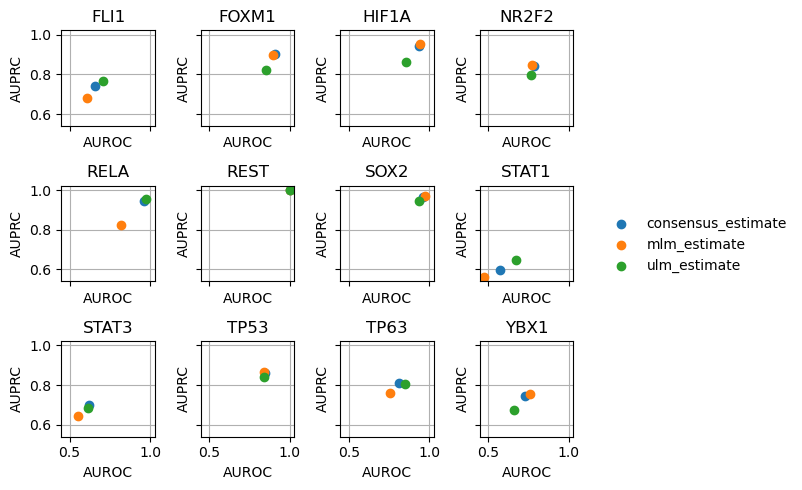

In [33]:
dc.plot_metrics_scatter_cols(
    df, col='source',
    figsize=(6, 5), groupby='method'
)

It looks like we get good predictions for HIF1A, RELA and SOX2 among others. On the other side, we worse predictions for STAT1.

HIF1A、RELA、SOX2などについては良い予測が得られたようだ。一方、STAT1の予測は悪かった。

### By meta-data groups

The benchmarking pipeline can also be run by grouping the input experiments using the `groupby` argument. Multiple groups can be selected at the same time but for simplicity, we will just test which knockout method seems to perform the best inhibitions:

ベンチマークパイプラインは、groupby引数を用いて入力実験をグループ化して実行することもできる。複数のグループを同時に選択することもできるが、ここでは簡単のため、どのノックアウト法が最も抑制効果が高いかをテストするだけにする：

In [37]:
# Example on how to set up decouple arguments
decouple_kws = {
    'methods': ['ulm', 'mlm'],
    'consensus': True,
}

In [35]:
# Run benchmark pipeline
df = dc.benchmark(
    mat, obs, collectri,
    perturb='TF', sign=-1,
    groupby='Knock.Method', verbose=True,
    decouple_kws=decouple_kws
)

Extracting inputs...
Formating net...
Removed 109 experiments without sources in net.
Running 279 experiments for 155 unique sources.
Running methods...
52 features of mat are empty, they will be removed.
Running ulm on mat with 279 samples and 21933 targets for 766 sources.
52 features of mat are empty, they will be removed.
Running mlm on mat with 279 samples and 21933 targets for 766 sources.
Calculating metrics...
Computing metrics for groupby Knock.Method...
Done.


Again, we can visualize the results in a collection of scatterplots:

ここでもまた、散布図の集まりで結果を視覚化することができる：

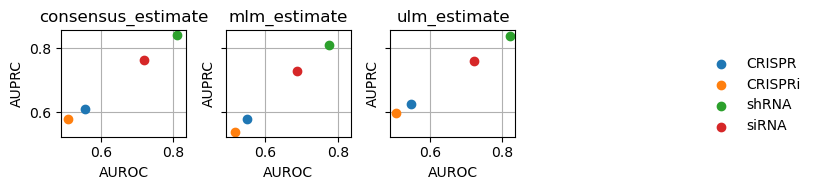

In [36]:
dc.plot_metrics_scatter_cols(
    df, col='method',
    figsize=(7, 2), groupby='group'
)

From our limited data-set, we can see that apparently shRNA works better than other knockout protocols.

私たちの限られたデータセットから、shRNAは他のノックアウトプロトコールよりもうまく機能することがわかる。